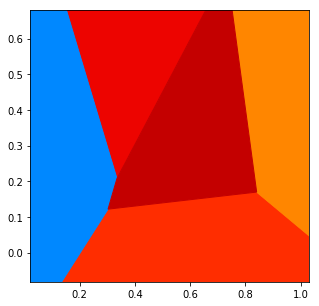

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi

def plot_vornoi_map(points, colors, ax=None, alpha=1., radius=None, norm=None, cmap=plt.cm.jet):
    def voronoi_finite_polygons_2d(vor, radius=radius):
        """
        Reconstruct infinite voronoi regions in a 2D diagram to finite
        regions.

        Parameters
        ----------
        vor : Voronoi
            Input diagram
        radius : float, optional
            Distance to 'points at infinity'.

        Returns
        -------
        regions : list of tuples
            Indices of vertices in each revised Voronoi regions.
        vertices : list of tuples
            Coordinates for revised Voronoi vertices. Same as coordinates
            of input vertices, with 'points at infinity' appended to the
            end.

        """

        if vor.points.shape[1] != 2:
            raise ValueError("Requires 2D input")

        new_regions = []
        new_vertices = vor.vertices.tolist()

        center = vor.points.mean(axis=0)
        if radius is None:
            radius = vor.points.ptp().max()

        # Construct a map containing all ridges for a given point
        all_ridges = {}
        for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
            all_ridges.setdefault(p1, []).append((p2, v1, v2))
            all_ridges.setdefault(p2, []).append((p1, v1, v2))

        # Reconstruct infinite regions
        for p1, region in enumerate(vor.point_region):
            vertices = vor.regions[region]

            if all(v >= 0 for v in vertices):
                # finite region
                new_regions.append(vertices)
                continue

            # reconstruct a non-finite region
            ridges = all_ridges[p1]
            new_region = [v for v in vertices if v >= 0]

            for p2, v1, v2 in ridges:
                if v2 < 0:
                    v1, v2 = v2, v1
                if v1 >= 0:
                    # finite ridge: already in the region
                    continue

                # Compute the missing endpoint of an infinite ridge

                t = vor.points[p2] - vor.points[p1] # tangent
                t /= np.linalg.norm(t)
                n = np.array([-t[1], t[0]])  # normal

                midpoint = vor.points[[p1, p2]].mean(axis=0)
                direction = np.sign(np.dot(midpoint - center, n)) * n
                far_point = vor.vertices[v2] + direction * radius

                new_region.append(len(new_vertices))
                new_vertices.append(far_point.tolist())

            # sort region counterclockwise
            vs = np.asarray([new_vertices[v] for v in new_region])
            c = vs.mean(axis=0)
            angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
            new_region = np.array(new_region)[np.argsort(angles)]

            # finish
            new_regions.append(new_region.tolist())

        return new_regions, np.asarray(new_vertices)

    # compute Voronoi tesselation
    vor = Voronoi(points)

    # plot
    regions, vertices = voronoi_finite_polygons_2d(vor)

    if ax is None:
        fig, ax = plt.subplots(1,1)
    # colorize
    for color,region in zip(colors,regions):
        if np.size(color) == 1:
            if norm is None:
                color = cmap(color)
            else:
                color = cmap(norm(color))
        polygon = vertices[region]
        ax.fill(*zip(*polygon), color=color, alpha=alpha)

    #plt.plot(points[:,0], points[:,1], 'ko')
    ax.set_xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
    ax.set_ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

fig, ax = plt.subplots(1,1,figsize=(5,5))
points = np.random.uniform(size=(5,2))
colors = np.random.uniform(size=5)
plot_vornoi_map(points, colors, ax=ax, alpha=1.,radius=100)
plt.show()

In [33]:
from bayes_filter.filters import FreeTransitionSAEM
import tensorflow as tf
import tensorflow_probability as tfp
import os
from bayes_filter.misc import load_array_file
from bayes_filter import float_type
import sys
from bayes_filter.data_feed import IndexFeed,TimeFeed,CoordinateFeed, DataFeed, init_feed, ContinueFeed
from bayes_filter.coord_transforms import tf_coord_transform, itrs_to_enu_with_references
from bayes_filter.kernels import DTECIsotropicTimeGeneralODE, DTECIsotropicTimeGeneral
import astropy.time as at
import astropy.coordinates as ac
import astropy.units as au
from bayes_filter.frames import ENU
import numpy as np
import pylab as plt
from scipy.spatial import cKDTree
import seaborn as sns
from timeit import default_timer
from bayes_filter.settings import angle_type, dist_type
from cmocean.cm import phase as phase_cmap

def arrays():
    return os.path.dirname(sys.modules["bayes_filter"].__file__)

def lofar_array(arrays):
    lofar_array = os.path.join(arrays, 'arrays/lofar.hba.antenna.cfg')
    return load_array_file(lofar_array)

def lofar_array2(arrays):
    lofar_array = os.path.join(arrays, 'arrays/lofar.hba.antenna.cfg')
    res = load_array_file(lofar_array)
    return res[0][[0,48,49,50, 51]], res[1][[0,48,49,50,51],:]


def simulated_ddtec(tf_session, lofar_array):
    class Simulated:
        def __init__(self):
            ref_ant = lofar_array[1][0,:]

            Nt, Nd, Na, Nf = 1, 20, len(lofar_array[0])-1, 6

            with tf_session.graph.as_default():
                index_feed = IndexFeed(Nt)
                obstime_init = at.Time("2018-01-01T00:00:00.000", format='isot')
                times = obstime_init.mjd*86400. + tf.cast(tf.linspace(0., Nt*30., Nt)[:, None],float_type)
                time_feed = TimeFeed(index_feed, times)
                cont_feed = ContinueFeed(time_feed)
                enu = ENU(location=ac.ITRS(*ref_ant * au.m), obstime=obstime_init)
                up = ac.SkyCoord(east=0., north=0., up=1., frame=enu).transform_to('icrs')

                M = 2
                self.M = M
                
                ra = np.random.uniform(up.ra.rad  - 2. * np.pi / 180., up.ra.rad  + 2. * np.pi / 180., size=M)[:,None]
                dec = np.random.uniform(up.dec.rad  - 2. * np.pi / 180., up.dec.rad  + 2. * np.pi / 180., size=M)[:,None]
                self.data_directions = np.stack([ra,dec],axis=1)
#                 ra_vec = np.linspace(up.ra.rad  - 2. * np.pi / 180., up.ra.rad  + 0. * np.pi / 180., M)
#                 dec_vec = np.linspace(up.dec.rad - 2. * np.pi / 180., up.dec.rad + 2. * np.pi / 180., M)
#                 self.data_extent = (ra_vec[0], ra_vec[-1], dec_vec[0], dec_vec[-1])
#                 ra, dec = np.meshgrid(ra_vec, dec_vec, indexing='ij')
#                 ra = ra.flatten()[:, None]
#                 dec = dec.flatten()[:, None]

                Nd = ra.shape[0]
                Xd  = tf.concat([ra, dec], axis=1)
                Xa  = tf.constant(lofar_array[1][1:,:], dtype=float_type)
                coord_feed = CoordinateFeed(time_feed, Xd, Xa,
                                            coord_map=tf_coord_transform(itrs_to_enu_with_references(ref_ant, [up.ra.rad, up.dec.rad], ref_ant)))
                ra_vec = np.linspace(up.ra.rad - 2. * np.pi / 180., up.ra.rad + 2. * np.pi / 180., M)
                dec_vec = np.linspace(up.dec.rad - 2. * np.pi / 180., up.dec.rad + 2. * np.pi / 180., M)
                self.star_extent = (ra_vec[0], ra_vec[-1], dec_vec[0], dec_vec[-1])
                ra, dec = np.meshgrid(ra_vec, dec_vec, indexing='ij')
                ra = ra.flatten()[:, None]
                dec = dec.flatten()[:, None]
                Nd_screen = ra.shape[0]

                Xd_screen = tf.concat([ra, dec], axis=1)
                star_coord_feed = CoordinateFeed(time_feed, Xd_screen, Xa,
                                                 coord_map=tf_coord_transform(itrs_to_enu_with_references(ref_ant, [up.ra.rad, up.dec.rad], ref_ant)))
                init, next = init_feed(coord_feed)
                init_star, next_star = init_feed(star_coord_feed)
                init_cont, cont = init_feed(cont_feed)
                Xd_screen, Xd, _,_,_ = tf_session.run([Xd_screen, Xd, init, init_cont, init_star])
                kern = DTECIsotropicTimeGeneral(variance=1e-4,timescale=45.,lengthscales=5., a=300., b=100.,
                                         fed_kernel='RBF',obs_type='DDTEC', squeeze=True, kernel_params={'resolution':3})
                # kern = tfp.positive_semidefinite_kernels.ExponentiatedQuadratic(tf.convert_to_tensor(0.04,float_type), tf.convert_to_tensor(10.,float_type))
                self.slice_size = Nt * Xd_screen.shape[0] * Xa.shape[0] + Nt * Xd.shape[0] * Xa.shape[0]

                kd = cKDTree(Xd)
                self.nearest, idx = kd.query(Xd_screen, k=1)
                self.nearest *= 180./np.pi
                from timeit import default_timer
                t0 = default_timer()
                Y_real, Y_imag = [],[]
                Y_real_star, Y_imag_star = [], []
                ddtec_true, ddtec_star = [],[]
                while True:
                    K,N = tf_session.run([kern.K(tf.concat([next,next_star],axis=0)),tf.shape(next)[0]])
                    s = np.mean(np.diag(K))
                    L = np.sqrt(s)*np.linalg.cholesky(K/s+1e-6*np.eye(K.shape[-1]))
                    np.random.seed(0)
                    ddtec = np.einsum('ab,b->a',L, np.random.normal(size=L.shape[1]))
                    ddtec_true.append(ddtec[:N])
                    ddtec_star.append(ddtec[N:])
                    freqs = np.linspace(110.e6, 160.e6, Nf)
                    Y_real.append(np.cos(-8.448e9 * ddtec[:N,None]/freqs))
                    Y_imag.append(np.sin(-8.448e9 * ddtec[:N, None] / freqs))
                    Y_real_star.append(np.cos(-8.448e9 * ddtec[N:, None] / freqs))
                    Y_imag_star.append(np.sin(-8.448e9 * ddtec[N:, None] / freqs))
                    if not tf_session.run(cont):
                        break
                self.Y_real_star = np.concatenate(Y_real_star,axis=0).reshape((Nt, Nd_screen, Na, Nf))
                self.Y_imag_star = np.concatenate(Y_imag_star, axis=0).reshape((Nt, Nd_screen, Na, Nf))
                Y_real_true = np.concatenate(Y_real,axis=0).reshape((Nt, Nd, Na, Nf))
                Y_real = Y_real_true + 0.5*np.random.normal(size=Y_real_true.shape)
                # Y_real[Nt//2:Nt//2 + 5, ...] *= 0.5
                Y_imag_true = np.concatenate(Y_imag, axis=0).reshape((Nt, Nd, Na, Nf))
                Y_imag = Y_imag_true + 0.5 * np.random.normal(size=Y_imag_true.shape)
                # Y_imag[Nt // 2:Nt // 2 + 5, ...] *= 0.5
                self.freqs = freqs
                self.ddtec_true = np.concatenate(ddtec_true,axis=0).reshape((Nt, Nd, Na))
                self.ddtec_star = np.concatenate(ddtec_star, axis=0).reshape((Nt, Nd_screen, Na))
                self.Y_real = Y_real
                self.Y_imag = Y_imag
                self.Y_real_true = Y_real_true
                self.Y_imag_true = Y_imag_true
                # self.np_freqs = tf_session.run(freqs)
                self.np_times = tf_session.run(times)
                self.ddtec = ddtec
                self.coord_feed = coord_feed
                self.star_coord_feed = star_coord_feed
                self.data_feed = DataFeed(index_feed, Y_real, Y_imag, event_size=1)
    return Simulated()

if __name__ == '__main__':
    from tensorflow.python import debug as tf_debug
    sess = tf.Session(graph=tf.Graph())
    # sess = tf_debug.LocalCLIDebugWrapperSession(sess)
    with sess.graph.as_default():
        simulated_ddtec = simulated_ddtec(sess, lofar_array2(arrays()))

        free_transition = FreeTransitionSAEM(
            simulated_ddtec.freqs,
            simulated_ddtec.data_feed,
            simulated_ddtec.coord_feed,
            simulated_ddtec.star_coord_feed)

        filtered_res, inits = free_transition.filter_step(
            num_samples=2000, num_chains=2,parallel_iterations=10, num_leapfrog_steps=3,target_rate=0.6,
            num_burnin_steps=1000,num_saem_samples=2000,saem_maxsteps=20,initial_stepsize=7e-3,
            init_kern_params={'y_sigma':0.5,'variance':0.5e-4,'timescale':45.,'lengthscales':15., 'a':500., 'b':60.},
            which_kernel=0, kernel_params={'resolution':3}, saem_batchsize=500, 
            slice_size=simulated_ddtec.slice_size)

        sess.run(inits[0])
        sess.run(inits[1])
        sess.run(inits[2])
        cont = True
        while cont:
            res = sess.run(filtered_res)
            print("rhat:",np.percentile(res.rhat,[10,50,90]))
            plt.hist(res.rhat, bins = int(np.sqrt(len(res.rhat))))
            plt.show()
            # plt.plot(res.step_sizes)
            # plt.show()
            # plt.hist(res.ess.flatten(),bins=100)
            # plt.show()
            times = simulated_ddtec.np_times[:,0]
            ddtec_true = simulated_ddtec.ddtec_true
            ddtec_star = simulated_ddtec.ddtec_star
            Y_real_star = simulated_ddtec.Y_real_star
            Y_imag_star = simulated_ddtec.Y_imag_star
            phase = np.arctan2(mulated_ddtec.extra.Y_imag_data,simulated_ddtec.extra.Y_real_data)
            


            # plt.plot(times, res.Y_imag[1,:,0,1,0],c='black',lw=2.)
            # plt.fill_between(times, res.Y_imag[0,:,0,1,0], res.Y_imag[2,:,0,1,0],alpha=0.5)
            # plt.plot(times, res.extra.Y_imag_data[:, 0, 1, 0], c='red', lw=1.)
            # plt.plot(times, simulated_ddtec.Y_imag_true[:, 0, 1, 0], c='green', lw=1.)
            # plt.show()
            ct = 1# -8.448e9/140e6
            vmin, vmax = np.percentile(ct*res.dtec_star[1, ...], [5, 95])

            plt.style.use('ggplot')
            fig, axs = plt.subplots((simulated_ddtec.Y_imag_true.shape[2]), 4, figsize=(12,4*(simulated_ddtec.Y_imag_true.shape[2])),sharex=True,sharey=True)
            # ax1,ax2, ax3 = axs[0]

            # ax1.imshow(res.dtec[1, 0, :, 1].reshape((simulated_ddtec.M,simulated_ddtec.M)).T,
            #            extent=simulated_ddtec.data_extent, 
            #            vmin=vmin,vmax=vmax)
            # ax1.set_title("Model space solution")

            # ax2.imshow(simulated_ddtec.dtec_star[0, :, 1].reshape((simulated_ddtec.M,simulated_ddtec.M)).T,
            #            extent=simulated_ddtec.star_extent,
            #            vmin=vmin,vmax=vmax)
            # ax2.set_title("Data space solution")
            # ax2.legend()

            ant_names = lofar_array2(arrays())[0][1:]

            for i in range(simulated_ddtec.Y_imag_true.shape[2]):
                ax3,ax4,ax5,ax6 = axs[i]

#                 ax3.imshow(ct*simulated_ddtec.ddtec_true[0, :, i].reshape((simulated_ddtec.M,simulated_ddtec.M)).T,
#                            extent=simulated_ddtec.data_extent,vmin=vmin,vmax=vmax)
#                 ax3.set_ylabel(ant_names[i])
                 
                plot_vornoi_map(simulated_ddtec.data_directions,phase[0,:,i],ax=ax3,radius = 10.,norm=plt.Normalize(-np.pi,np.pi),cmap=phase_cmap)

                ax3.scatter(ct*simulated_ddtec.ddtec_true[0, :, i].reshape((simulated_ddtec.M,simulated_ddtec.M)).T,
                           extent=simulated_ddtec.data_extent,vmin=vmin,vmax=vmax)
                ax3.set_ylabel(ant_names[i])


                ax4.imshow(ct*res.dtec_star[1, 0, :, i].reshape((simulated_ddtec.M,simulated_ddtec.M)).T,
                           extent=simulated_ddtec.star_extent,vmin=vmin,vmax=vmax)


                img = ax5.imshow(ct*(ddtec_star[0, :, i]).reshape((simulated_ddtec.M,simulated_ddtec.M)).T,
                                 extent=simulated_ddtec.star_extent, vmin=vmin,vmax=vmax)


                img = ax6.imshow(ct*np.abs(res.dtec_star[1, 0, :, i] - ddtec_star[0, :, i]).reshape((simulated_ddtec.M,simulated_ddtec.M)).T,
                                 extent=simulated_ddtec.star_extent, vmin=vmin,vmax=vmax)
                if i == 0:
                    ax3.set_title(r"Obs. $\Delta^2$TEC")
                    ax4.set_title(r"Median inferred $\Delta^2$TEC*")
                    ax5.set_title(r"True $\Delta^2$TEC*")
                    ax6.set_title(r"Residual $\Delta^2$TEC")

            #         ax3.set_title(r"True $\Delta^2$TEC(X)")
            #         ax4.set_title(r"Median $\Delta^2$TEC(X*)")
            #         ax5.set_title(r"True $\Delta^2$TEC(X*)")
            #         ax6.set_title(r"Residual $\Delta^2$TEC(X*)")

            # plt.tight_layout()
            cbaxes = fig.add_axes([0.95, 0.1, 0.03, 0.8]) 
            cb = plt.colorbar(img, cax = cbaxes)  
            plt.savefig('screen_interpolation.png')
            plt.show()
            # error = np.sqrt(np.square(res.Y_imag_star[1, :, :, :, :]-simulated_ddtec.Y_imag_star[:, :, :, :]).mean(3).mean(2).mean(0))
            # plt.scatter(simulated_ddtec.nearest,error)
            # x = simulated_ddtec.nearest[:, None]
            # a, _, _, _ = np.linalg.lstsq(x, error)
            # plt.plot(x, a * x, 'r-')
            # plt.show()

            error = np.sqrt(
                np.square(ct*res.dtec_star[1, :, :, :] - ct*simulated_ddtec.ddtec_star[:, :, :]).mean(
                    2).mean(0))
            plt.scatter(simulated_ddtec.nearest, error)
            x = simulated_ddtec.nearest[:, None]
            a, _, _, _ = np.linalg.lstsq(x, error)
            plt.plot(x, a * x, 'r-')
            plt.xlabel('Nearest facet angular distance (deg)')
            plt.ylabel('Residual phase (rad)')
            plt.show()
            cont = res.cont

KeyboardInterrupt: 

In [3]:
%matplotlib inline

rhat: [1.00357052 1.08491968 1.49817301] [1.08683597 1.27069069 1.45917514 ... 1.22533058 1.01448681 1.6305369 ]


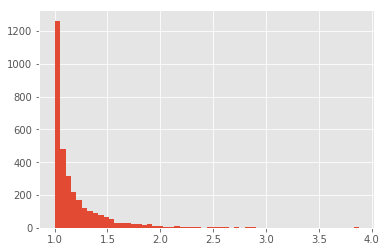

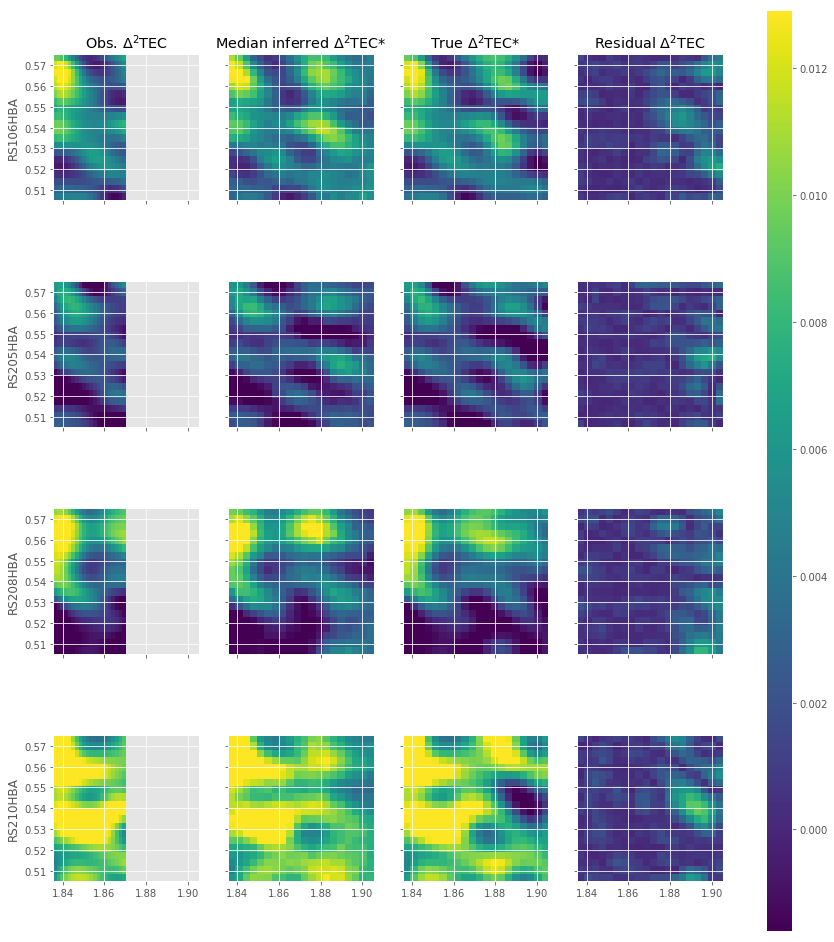

/home/albert/miniconda3/envs/bayes_filter/lib/python3.7/site-packages/ipykernel_launcher.py:87: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


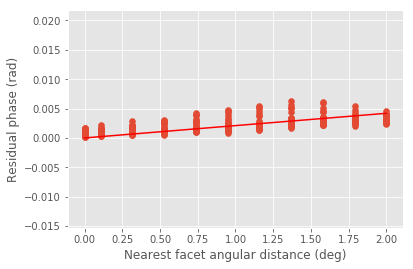

In [48]:
# print("post_logp", res.post_logp,"test_logp", res.test_logp)


In [2]:
plt.show()